# Cork South Link Road - Data Analysis

# Import needed packages

In [143]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis
# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score, max_error

from time import process_time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError

from sklearn.neural_network import MLPRegressor

# Import Raw Data

In [144]:
df = pd.read_csv('./Cork Airport Met and Pollutant Data 17-19 (Rows Deleted and Hour Fixed).csv', thousands=',', low_memory=False)
# You can also open with Excel and take a look at it.

# Let's Look at the Data

In [145]:
df.head(5)

,Date,Hour,indrain,rain,indtemp,temp,indwetb,wetb,dewpt,vappr,...,w,sun,vis,clht,clamt,Ozone,SO2,NO2,CO,PM10
0,01/01/2017 00:00,0,0,1.4,0,8.0,0,7.6,7.1,10.1,...,62,0.0,9000,22,8,NaN,NaN,NaN,NaN,NaN
1,01/01/2017 01:00,1,0,1.7,0,6.1,0,5.7,5.1,8.8,...,66,0.0,20000,8,8,NaN,NaN,NaN,NaN,NaN
2,01/01/2017 02:00,2,0,0.2,0,4.8,0,4.3,3.6,7.9,...,62,0.0,25000,80,7,NaN,NaN,NaN,NaN,NaN
3,01/01/2017 03:00,3,0,0.0,0,4.8,0,4.3,3.5,7.9,...,62,0.0,25000,10,7,NaN,NaN,NaN,NaN,NaN
4,01/01/2017 04:00,4,0,0.1,0,4.3,0,3.6,2.6,7.3,...,62,0.0,30000,50,7,NaN,NaN,NaN,NaN,NaN


In [146]:
df.tail(5)

,Date,Hour,indrain,rain,indtemp,temp,indwetb,wetb,dewpt,vappr,...,w,sun,vis,clht,clamt,Ozone,SO2,NO2,CO,PM10
25433,31/12/2019 19:00,19,0,0.0,0,6.7,0,6.3,5.7,9.2,...,11,0.0,20000,11,6,NaN,4.8,38.8,0.8,NaN
25434,31/12/2019 20:00,20,3,0.0,0,6.1,0,5.8,5.3,9.0,...,11,0.0,20000,999,3,4.79,5.1,41.6,0.9,NaN
25435,31/12/2019 21:00,21,3,0.0,0,6.0,0,5.7,5.4,8.9,...,11,0.0,20000,21,5,5.39,5.6,39.7,1.2,NaN
25436,31/12/2019 22:00,22,3,0.0,0,5.8,0,5.5,5.2,8.8,...,22,0.0,2200,25,7,4.79,2.9,37.1,0.9,NaN
25437,31/12/2019 23:00,23,3,0.0,0,5.8,0,5.6,5.3,8.9,...,22,0.0,4500,26,7,5.19,3.2,34.2,1.0,NaN


# Look at Meteorological Indicators
This identifies the presence of bad data and what needs to be removed as explained at the other two sites

In [147]:
df['indrain'].value_counts()

0    18779
3     3843
2     2784
1       32
Name: indrain, dtype: int64

In [148]:
df['indtemp'].value_counts()

0    25246
1      192
Name: indtemp, dtype: int64

In [149]:
df['indwetb'].value_counts()

0    25101
1      307
5       30
Name: indwetb, dtype: int64

In [150]:
df['indwdsp'].value_counts()

2    25438
Name: indwdsp, dtype: int64

In [151]:
df['indwddir'].value_counts()

2    25438
Name: indwddir, dtype: int64

# Remove bad Data

In [152]:
#Code to remove the junk data row
import csv

with open('./Cork Airport Met and Pollutant Data 17-19 (Rows Deleted and Hour Fixed).csv', 'r') as fin, open('Cork_FileforML.csv', 'w', newline='') as fout:

    # define reader and writer objects
    reader = csv.reader(fin, skipinitialspace=True)
    writer = csv.writer(fout, delimiter=',')

    # write headers
    writer.writerow(next(reader))

    # iterate and write rows based on condition
    for i in reader:
        if int(i[2]) == 0 and int(i[4]) == 0 and int(i[6]) == 0:
            writer.writerow(i)
#Assign the final clean data to a new dataframe
Cdf = pd.read_csv('Cork_FileforML.csv', thousands=',', low_memory=False)

In [153]:
#Drop any "None rows"
Cdf = Cdf.dropna(axis=0)
print("The number of rows in the input data is: {}".format(len(Cdf)))

The number of rows in the input data is: 5520


In [154]:
#Sanity check
Cdf.head(5)

,Date,Hour,indrain,rain,indtemp,temp,indwetb,wetb,dewpt,vappr,...,w,sun,vis,clht,clamt,Ozone,SO2,NO2,CO,PM10
11427,10/11/2018 16:00,16,0,0.0,0,12.5,0,10.1,7.5,10.4,...,11,0.9,60000,999,2,42.6,3.0,35.1,0.3,33.4
11428,10/11/2018 17:00,17,0,0.0,0,11.9,0,10.0,8.1,10.8,...,11,0.5,50000,999,1,49.2,2.2,20.1,0.2,26.0
11429,10/11/2018 18:00,18,0,0.0,0,11.1,0,9.7,8.2,10.9,...,81,0.0,40000,999,4,57.0,2.2,9.2,0.2,17.0
11430,10/11/2018 19:00,19,0,0.0,0,11.3,0,9.9,8.4,11.1,...,11,0.0,30000,999,4,64.4,2.2,6.5,0.2,18.0
11431,10/11/2018 20:00,20,0,0.0,0,12.0,0,10.7,9.4,11.8,...,11,0.0,25000,18,7,66.6,2.2,5.3,0.2,14.0


In [155]:
Cdf.tail(5)

,Date,Hour,indrain,rain,indtemp,temp,indwetb,wetb,dewpt,vappr,...,w,sun,vis,clht,clamt,Ozone,SO2,NO2,CO,PM10
18574,31/12/2019 02:00,2,0,0.1,0,8.3,0,8.1,7.9,10.6,...,52,0.0,20000,20,7,58.47,1.9,13.6,0.3,9.0
18575,31/12/2019 03:00,3,0,0.0,0,8.2,0,8.0,7.7,10.6,...,52,0.0,20000,12,7,60.27,2.1,6.9,0.3,11.0
18576,31/12/2019 04:00,4,0,0.2,0,7.9,0,7.7,7.4,10.3,...,52,0.0,7000,4,7,61.87,2.1,6.5,0.3,9.0
18577,31/12/2019 06:00,6,0,0.0,0,8.1,0,7.8,7.4,10.3,...,52,0.0,20000,5,7,57.28,2.1,7.8,0.3,16.0
18578,31/12/2019 07:00,7,0,0.0,0,8.1,0,7.8,7.5,10.3,...,11,0.0,18000,4,7,51.49,2.1,5.2,0.3,16.0


# Look at the column datatypes

In [156]:
Cdf.dtypes #Look at the datatypes

Date         object
Hour          int64
indrain       int64
rain        float64
indtemp       int64
temp        float64
indwetb       int64
wetb        float64
dewpt       float64
vappr       float64
rhum          int64
msl         float64
indwdsp       int64
wdsp          int64
indwddir      int64
wddir         int64
ww            int64
w             int64
sun         float64
vis           int64
clht          int64
clamt         int64
Ozone       float64
SO2         float64
NO2         float64
CO          float64
PM10        float64
dtype: object

In [157]:
#Change the datatype of the date column (used for selecting timeframes later)
Cdf['Date'] = Cdf['Date'].astype('datetime64') 

In [158]:
Cdf.dtypes

Date        datetime64[ns]
Hour                 int64
indrain              int64
rain               float64
indtemp              int64
temp               float64
indwetb              int64
wetb               float64
dewpt              float64
vappr              float64
rhum                 int64
msl                float64
indwdsp              int64
wdsp                 int64
indwddir             int64
wddir                int64
ww                   int64
w                    int64
sun                float64
vis                  int64
clht                 int64
clamt                int64
Ozone              float64
SO2                float64
NO2                float64
CO                 float64
PM10               float64
dtype: object

# Plot Feature Time Series

<Figure size 1800x720 with 0 Axes>

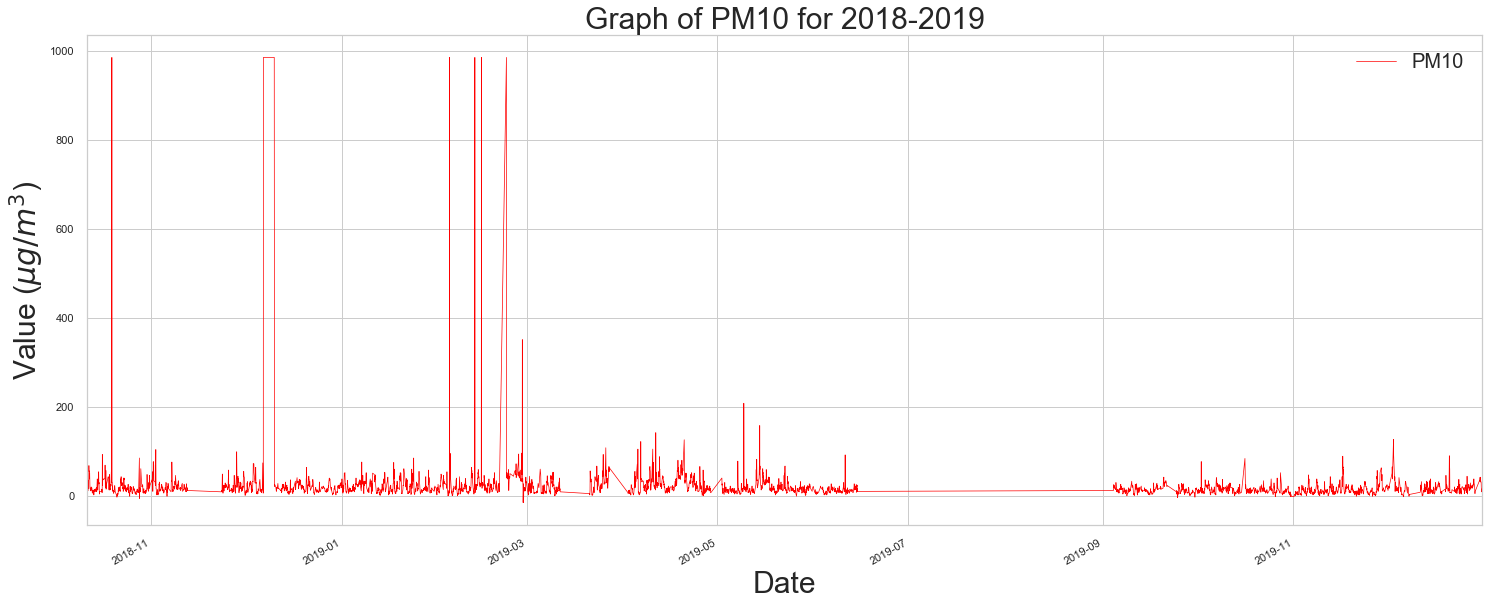

<Figure size 1800x720 with 0 Axes>

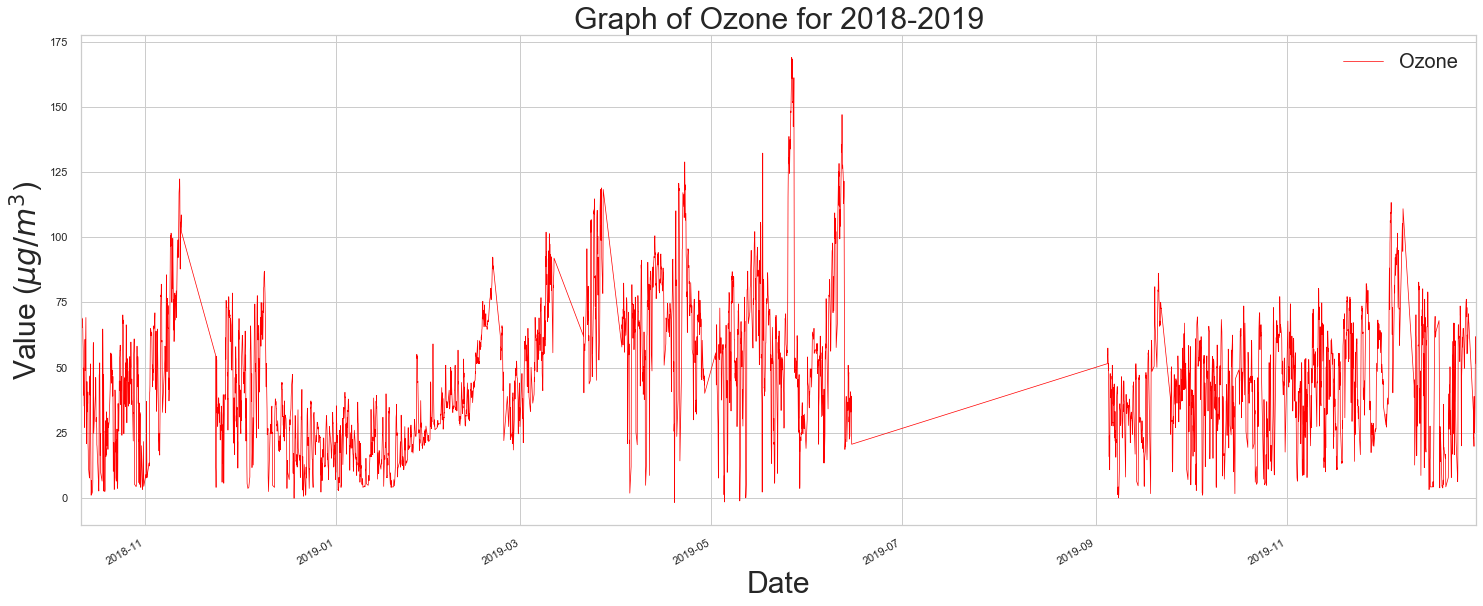

<Figure size 1800x720 with 0 Axes>

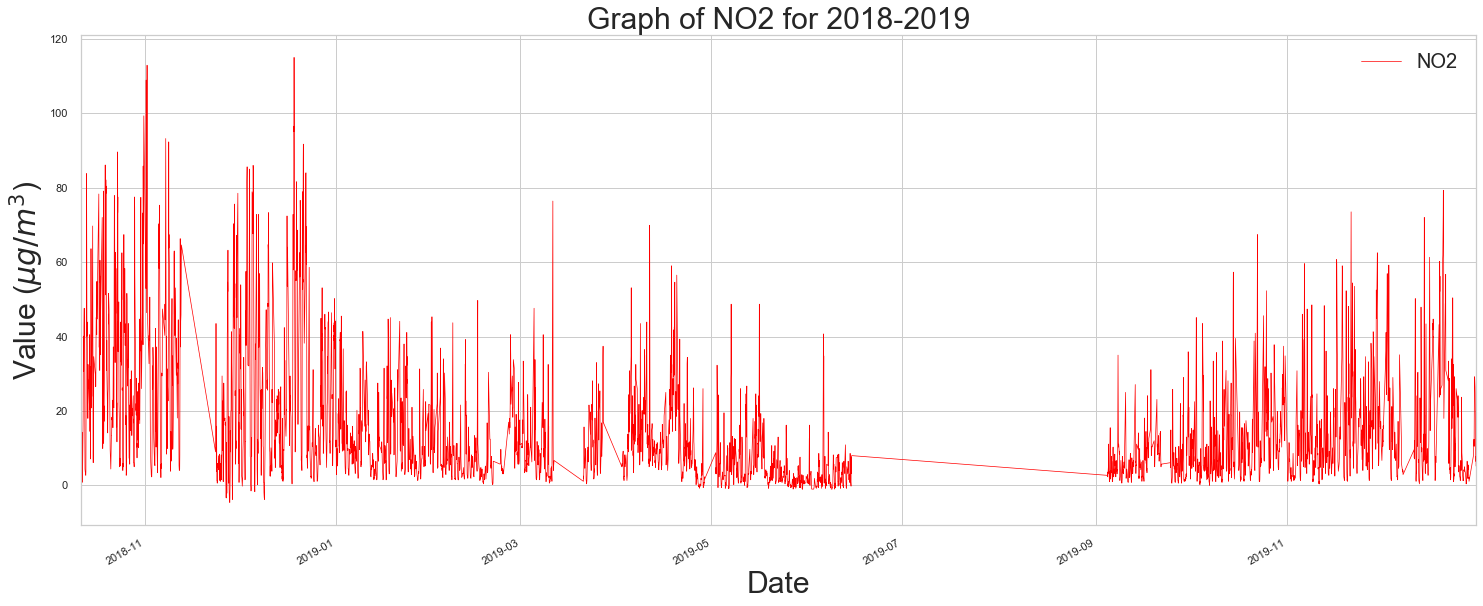

<Figure size 1800x720 with 0 Axes>

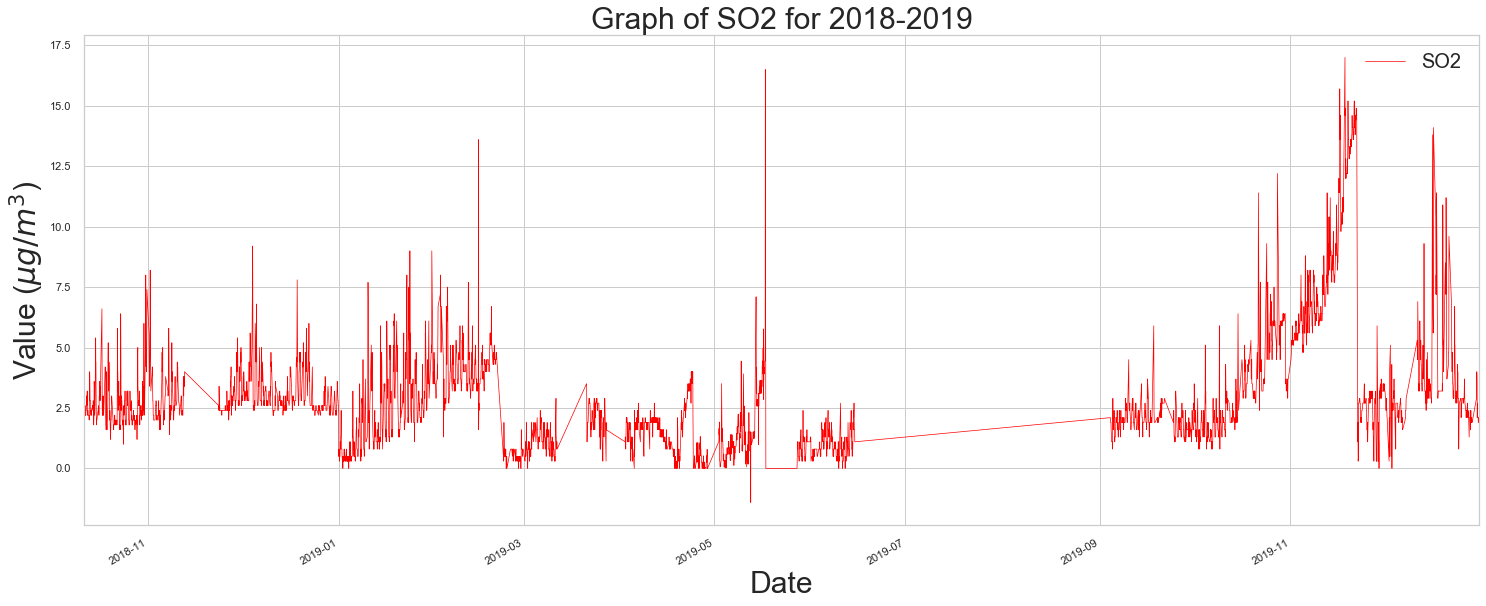

<Figure size 1800x720 with 0 Axes>

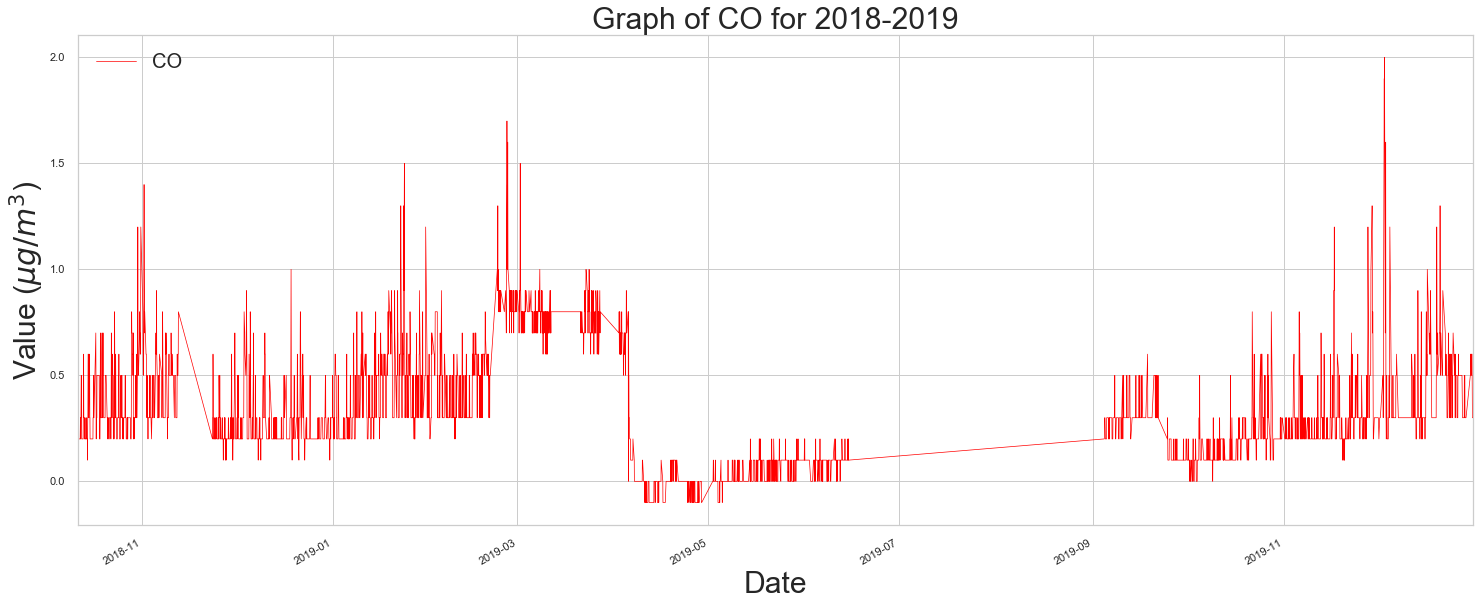

In [159]:
#Let's plot
from matplotlib.pyplot import figure

def PlotFeature(Name, Data1):
    
    Feature = []
    Feature = Data1[Name].values

    Date = []
    Date = Data1['Date'].values

    N_data = len(Data1)
    N = np.zeros(N_data)

    for i in range(N_data):
        N[i] = i
        
    
    Plotsdf = pd.DataFrame(list(zip(Date, Feature)), columns=['Date', Name])
    
    
    figure(figsize=(25, 10))
    
    
    Plotsdf.plot(x='Date', y=Name, linewidth=0.7, figsize=(25, 10), color=['red'])
    plt.title("Graph of {} for 2018-2019".format(Name), fontsize=30)
    plt.xlabel("Date", fontsize=30)
    plt.ylabel("Value ($\mu g / m^{3}$)", fontsize=30)
    plt.legend(fontsize=20)
    plt.show()
    
PlotFeature('PM10', Cdf)
PlotFeature('Ozone', Cdf)
PlotFeature('NO2', Cdf)
PlotFeature('SO2', Cdf)
PlotFeature('CO', Cdf)


Number of rows in positive cleaned dataset is: 5240


<Figure size 1800x720 with 0 Axes>

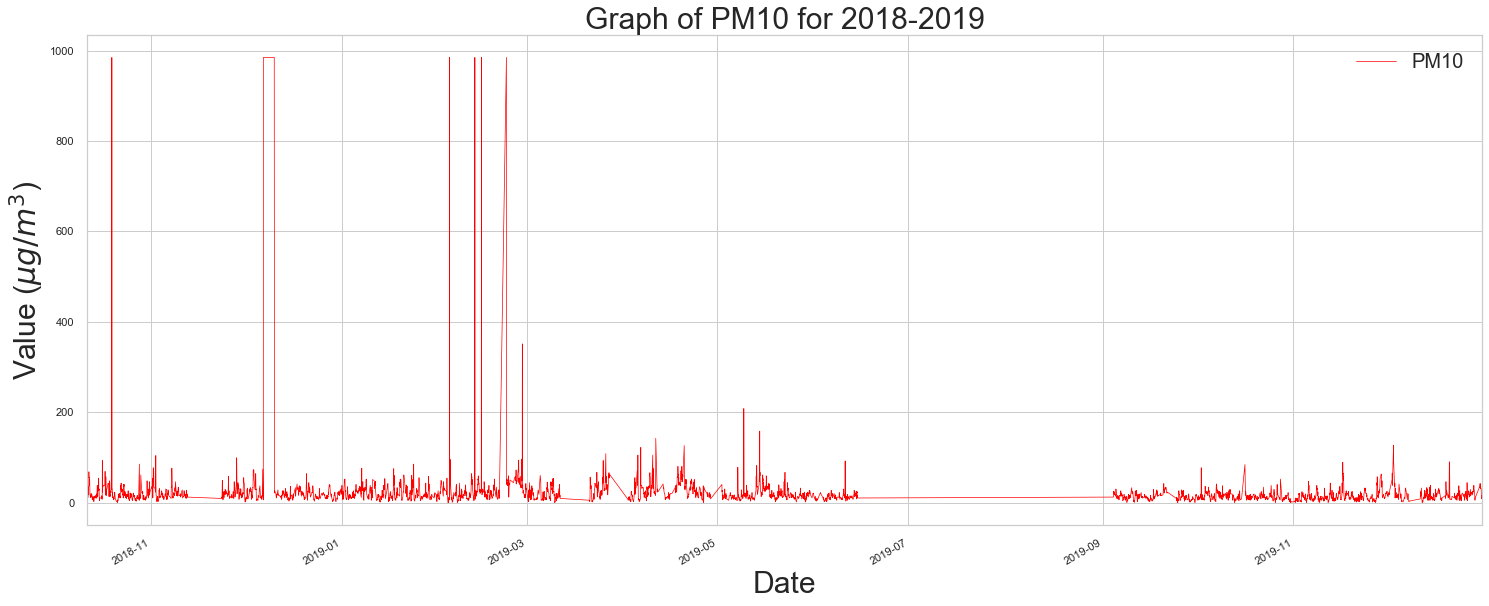

<Figure size 1800x720 with 0 Axes>

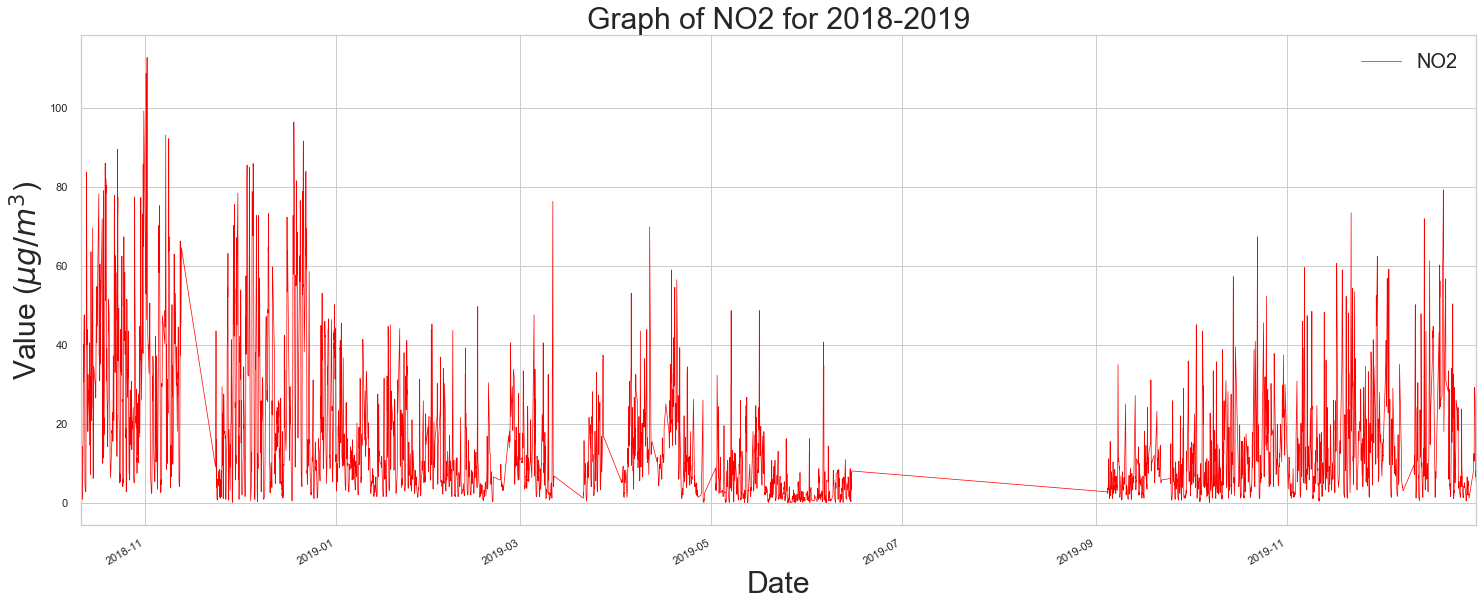

<Figure size 1800x720 with 0 Axes>

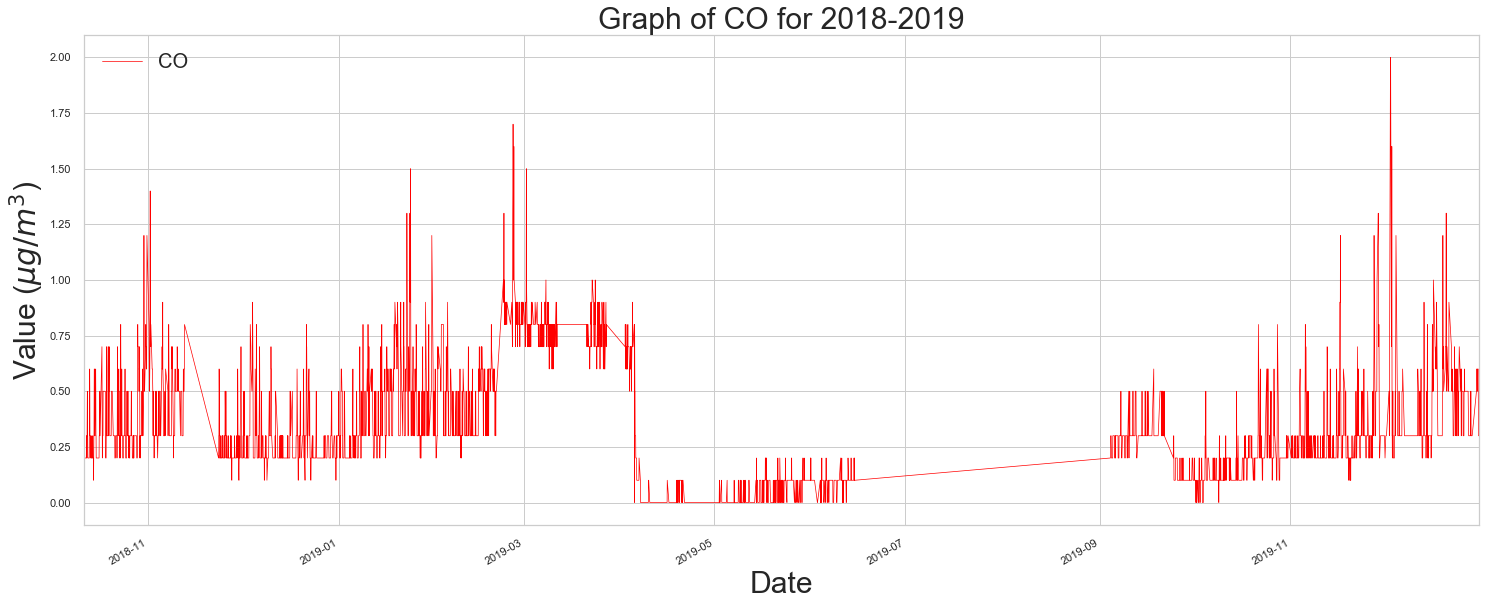

<Figure size 1800x720 with 0 Axes>

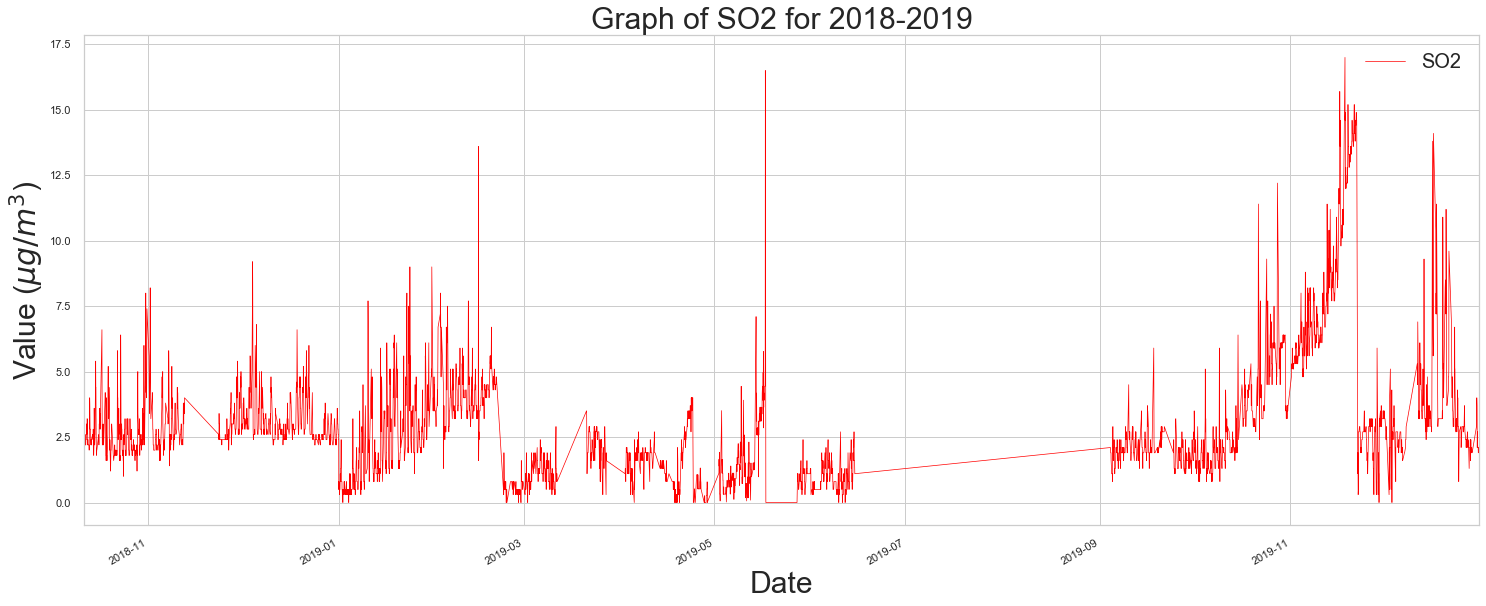

<Figure size 1800x720 with 0 Axes>

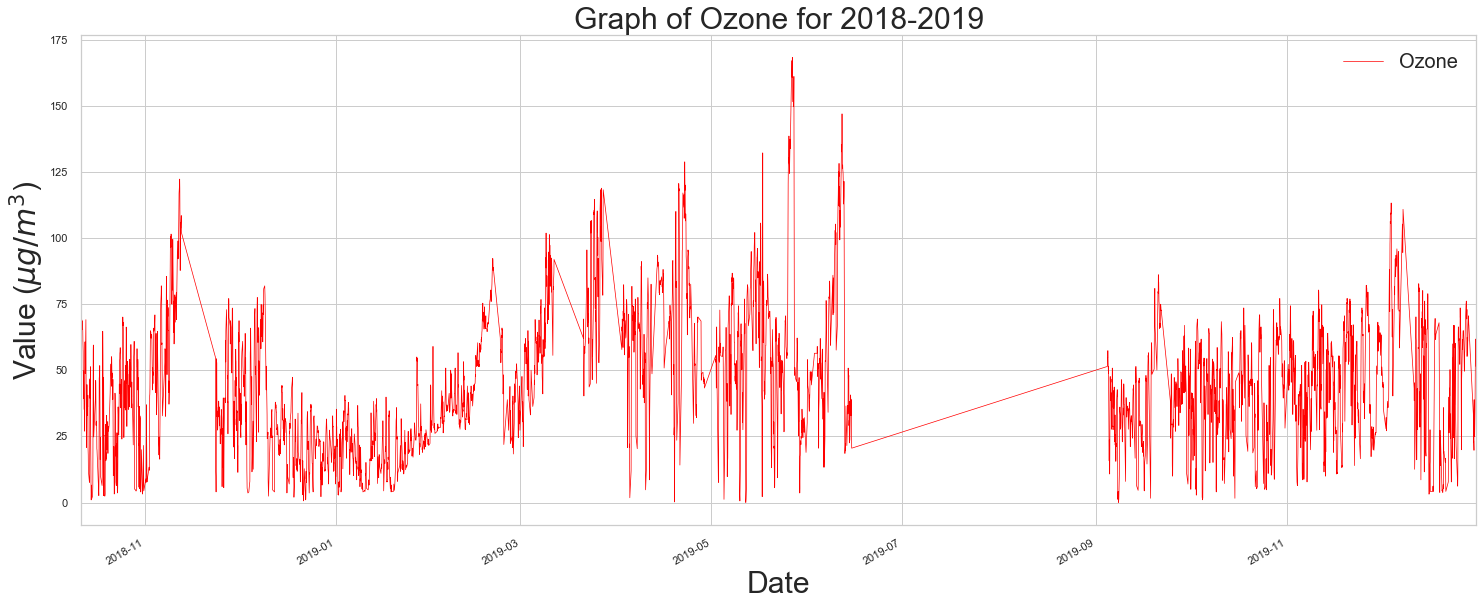

In [160]:
#Only take positive values
Posdf = Cdf[(Cdf['SO2'] >= 0) & (Cdf['Ozone'] >= 0) & (Cdf['NO2'] >= 0) & (Cdf['CO'] >= 0) & (Cdf['PM10'] >= 0)]

#Drop rows containing "None"
Posdf = Posdf.dropna(axis=0)

print("Number of rows in positive cleaned dataset is: {}".format(len(Posdf)))

PlotFeature('PM10', Posdf)
PlotFeature('NO2', Posdf)
PlotFeature('CO', Posdf)
PlotFeature('SO2', Posdf)
PlotFeature('Ozone', Posdf)

In [122]:
Posdf.head()

,Date,Hour,indrain,rain,indtemp,temp,indwetb,wetb,dewpt,vappr,...,w,sun,vis,clht,clamt,Ozone,SO2,NO2,CO,PM10
11427,2018-10-11 16:00:00,16,0,0.0,0,12.5,0,10.1,7.5,10.4,...,11,0.9,60000,999,2,42.6,3.0,35.1,0.3,33.4
11428,2018-10-11 17:00:00,17,0,0.0,0,11.9,0,10.0,8.1,10.8,...,11,0.5,50000,999,1,49.2,2.2,20.1,0.2,26.0
11429,2018-10-11 18:00:00,18,0,0.0,0,11.1,0,9.7,8.2,10.9,...,81,0.0,40000,999,4,57.0,2.2,9.2,0.2,17.0
11430,2018-10-11 19:00:00,19,0,0.0,0,11.3,0,9.9,8.4,11.1,...,11,0.0,30000,999,4,64.4,2.2,6.5,0.2,18.0
11431,2018-10-11 20:00:00,20,0,0.0,0,12.0,0,10.7,9.4,11.8,...,11,0.0,25000,18,7,66.6,2.2,5.3,0.2,14.0


# Drop all uneccesary Columns

In [123]:
Posdf.drop('Date', axis=1, inplace=True)

In [124]:
Posdf.drop('indrain', axis=1, inplace=True)

In [125]:
Posdf.drop('indtemp', axis=1, inplace=True)

In [126]:
Posdf.drop('indwetb', axis=1, inplace=True)

In [127]:
Posdf.drop('indwdsp', axis=1, inplace=True)

In [128]:
Posdf.drop('indwddir', axis=1, inplace=True)

In [129]:
Posdf.drop('ww', axis=1, inplace=True)

In [130]:
Posdf.drop('w', axis=1, inplace=True)

In [131]:
Posdf.drop('rhum', axis=1, inplace=True)

In [132]:
Posdf.drop('vappr', axis=1, inplace=True)

In [133]:
Posdf.drop('wetb', axis=1, inplace=True)

In [134]:
Posdf.drop('dewpt', axis=1, inplace=True)

# Let's look at the data for input into Algorithms

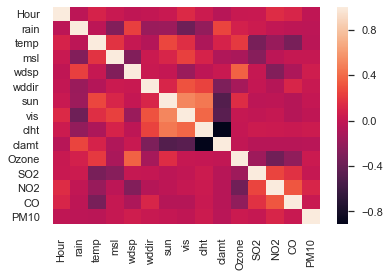

In [135]:
#Heatmap
sns.heatmap(Posdf.corr());

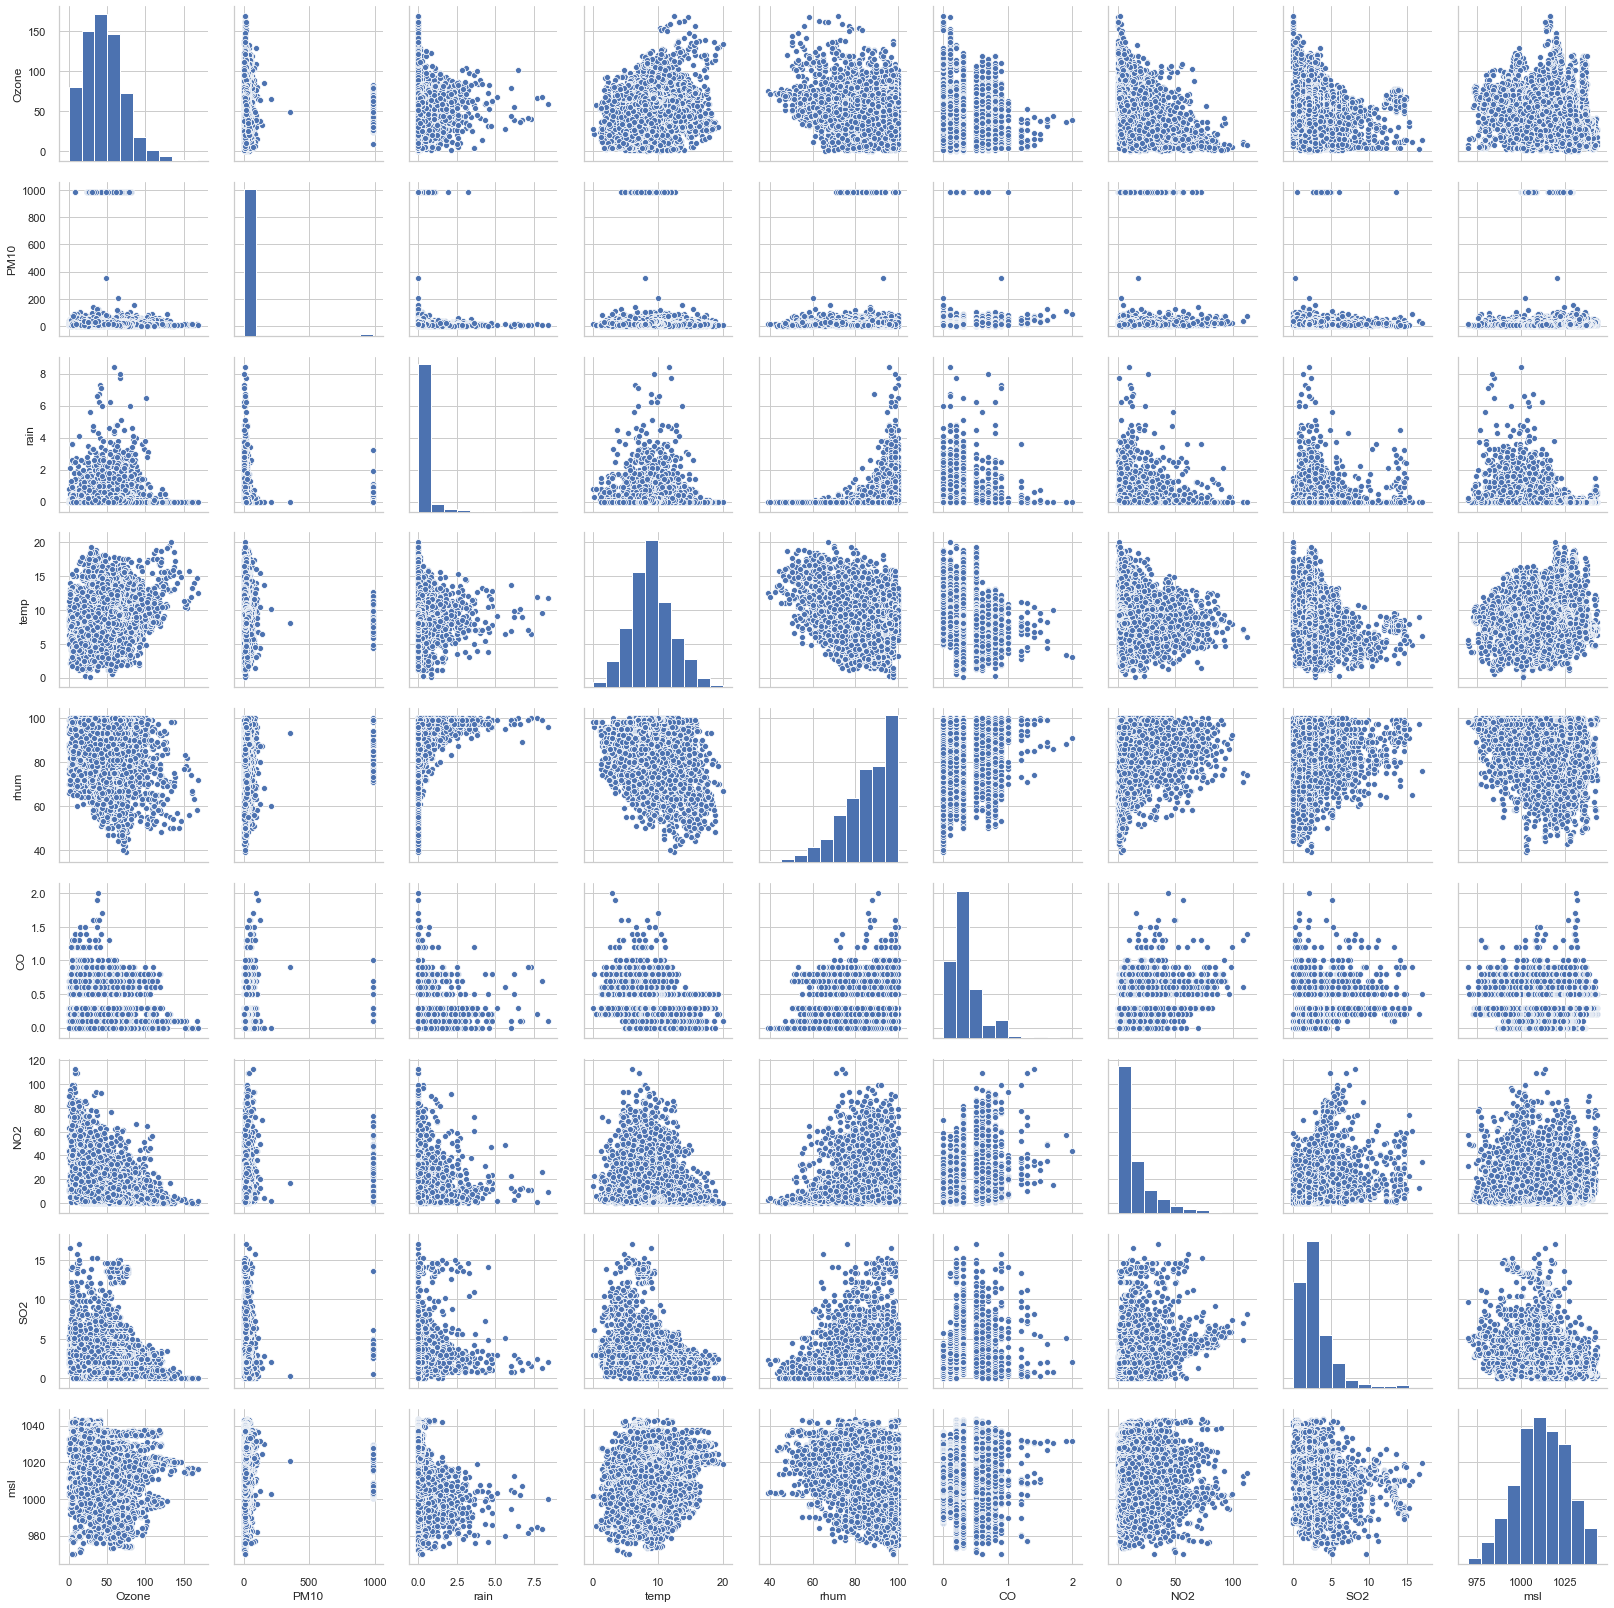

In [161]:
sns.pairplot(data=Posdf[['Ozone','PM10','rain','temp','rhum', 'CO', 'NO2', 'SO2', 'msl']].dropna())
plt.show()

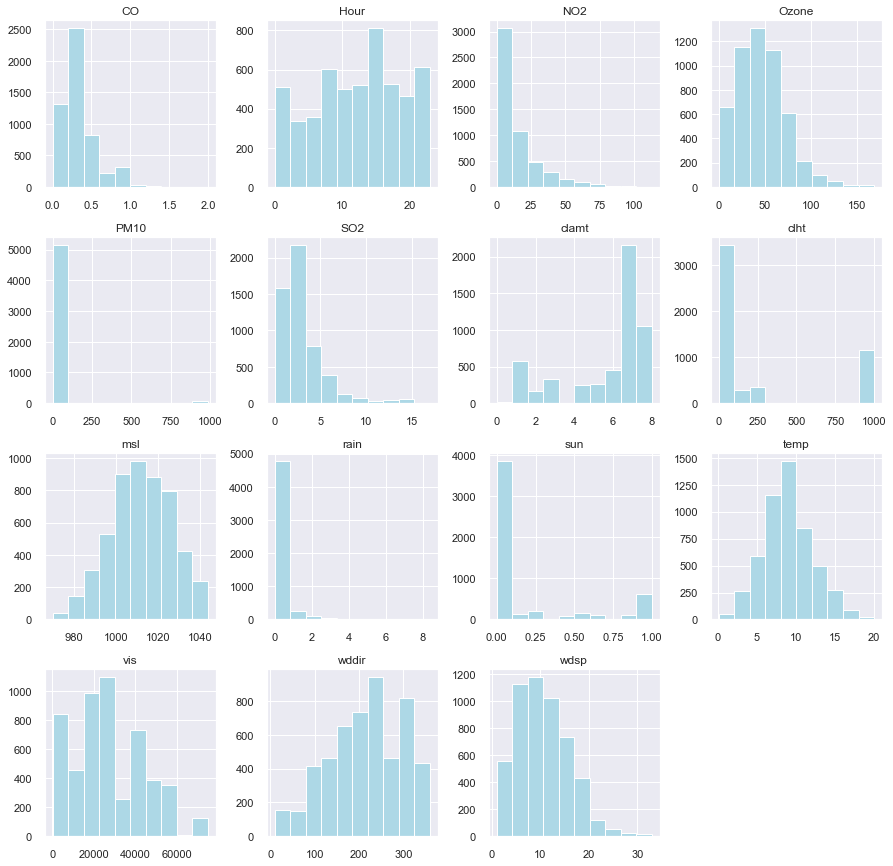

In [137]:
#Histograms
sns.set()
pd.DataFrame.hist(Posdf, figsize = [15,15], color='lightblue')
plt.show()

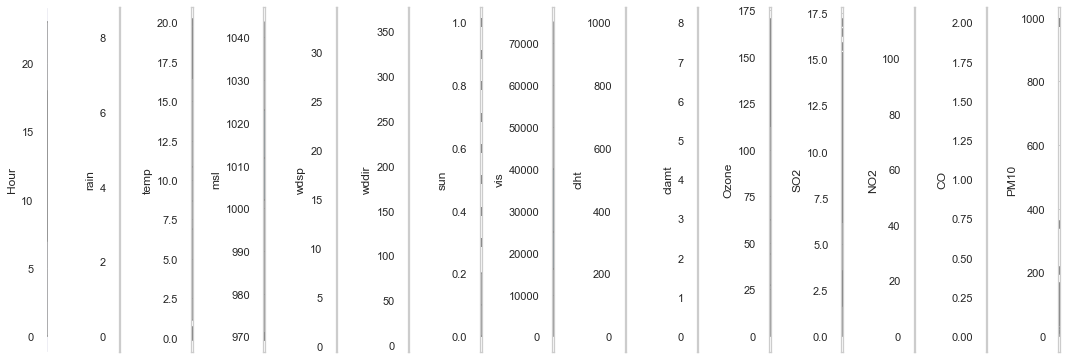

In [138]:
l = Posdf.columns.values
number_of_columns=21
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(Posdf[l[i]],color='lightblue',orient='v')
    plt.tight_layout()

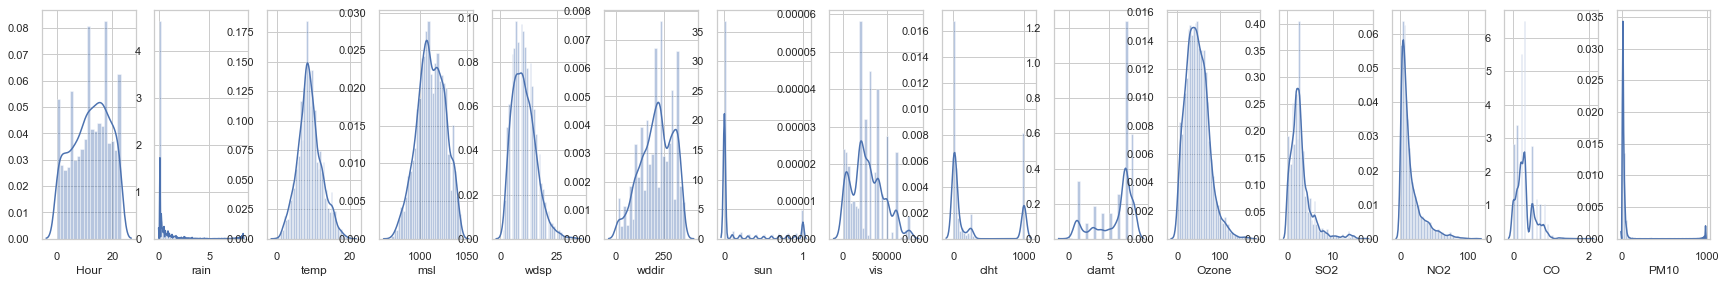

In [139]:
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(Posdf[l[i]],kde=True)

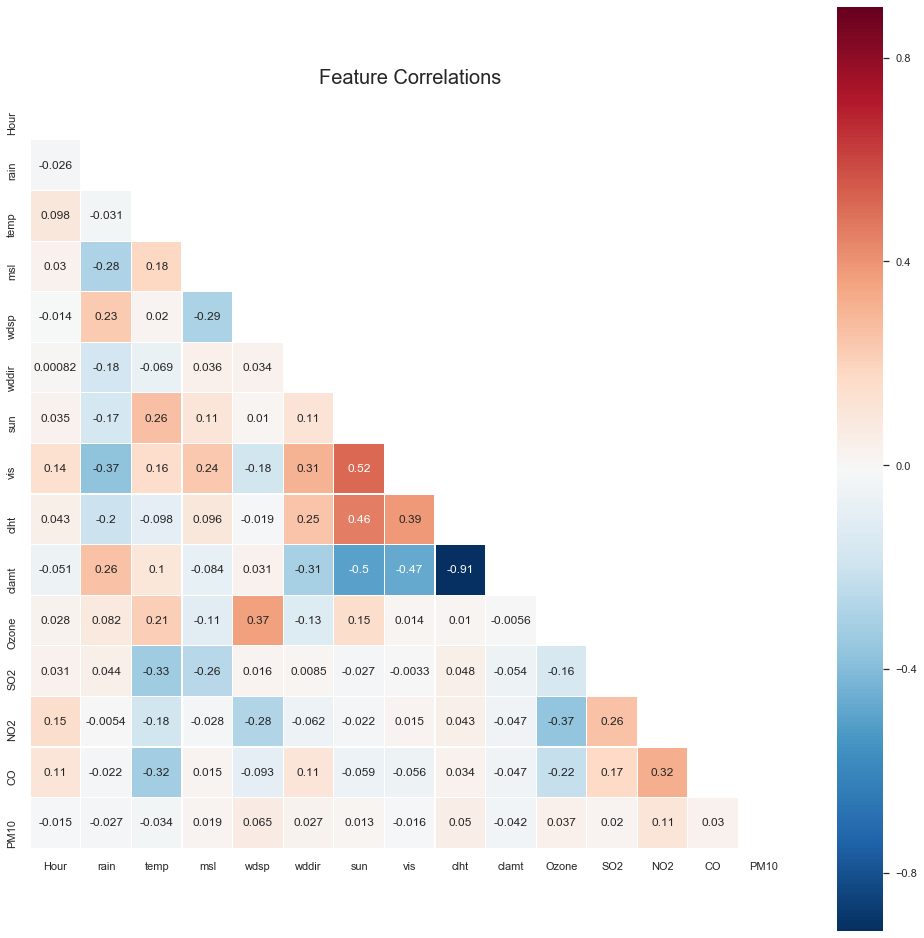

In [140]:
mask = np.zeros_like(Posdf.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (17,17))
sns.heatmap(Posdf.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Feature Correlations", y = 1.03,fontsize = 20)
plt.show()

In [141]:
Posdf.describe()

,Hour,rain,temp,msl,wdsp,wddir,sun,vis,clht,clamt,Ozone,SO2,NO2,CO,PM10
count,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.00000,5240.000000,5240.000000,5240.000000
mean,12.232061,0.234370,8.969828,1011.994943,10.483015,213.209924,0.179122,28000.648855,259.689504,5.797137,46.124979,2.91187,14.864225,0.311050,30.653321
std,6.537656,0.659464,3.192377,14.499581,5.102022,83.502276,0.343048,17828.567305,397.361023,2.295807,25.707553,2.39450,16.232097,0.244532,107.218056
min,0.000000,0.000000,0.100000,970.100000,1.000000,10.000000,0.000000,100.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,6.900000,1002.000000,7.000000,150.000000,0.000000,16000.000000,11.000000,4.000000,27.340000,1.60000,4.200000,0.200000,9.000000
50%,13.000000,0.000000,8.700000,1011.700000,10.000000,220.000000,0.000000,25000.000000,35.000000,7.000000,44.000000,2.40000,9.000000,0.300000,15.000000
75%,18.000000,0.100000,10.800000,1023.025000,14.000000,280.000000,0.100000,40000.000000,250.000000,7.000000,62.270000,3.50000,19.700000,0.500000,24.000000
max,23.000000,8.400000,20.000000,1043.500000,33.000000,360.000000,1.000000,75000.000000,999.000000,8.000000,168.440000,17.00000,112.900000,2.000000,985.000000
